# Find population of a US CITY based on
    
    ALAND
    AWATER
    LAT
    LONG
    STATE
    UAtype


steps to train a DNN¶
1. Prepare data
_ clean data
_ vectorize/encode data
_ split data in train,validation and test data
2. Train model
_ create model and layers
_ compile mode(optimizer , metrics, loss)
_ fit model(train data, validation data, epochs, mini batch size)
3. Validate model
_ validate on test data
4. Repeat


In [3]:
import pandas as pd
import numpy as np


In [4]:
#prepare data
city_data = []
#00037	Abbeville, LA Urban Cluster	C	19824	8460	29222871	300497	      11.283	       0.116	 29.967602	 -92.098219  
def parseline(line):
    parts = line.split('\t')
    data={}
    namepart = parts[1].split(',')
    data['NAME']=namepart[0]
    data['STATE']=namepart[1].strip().split()[0].strip()
    data['UAtype']=parts[2]
    data['POP10']= int(parts[3])
    data['ALAND']= int(parts[5])
    data['AWATER']= int(parts[6])
    data['LAT']=float(parts[9])
    data['LONG']=float(parts[10])
    return data
with open('Gaz_ua_national.txt','r') as file:
    city_data = [ parseline(line.strip()) for line in file.readlines()[1:]]

In [5]:
city_data[-1]

{'NAME': 'Zuni Pueblo',
 'STATE': 'NM',
 'UAtype': 'C',
 'POP10': 6744,
 'ALAND': 11876813,
 'AWATER': 0,
 'LAT': 35.071062,
 'LONG': -108.823725}

In [6]:
len(city_data)

3592

In [7]:
df = pd.DataFrame(city_data)
df = df.sample(len(df))#shuffle
df.head()

,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype
1407,47328615,111296,36.316527,-78.402573,Henderson,20858,NC,C
2746,69506203,0,26.375238,-98.850736,Rio Grande City--Roma,46344,TX,C
3030,18828106,635980,60.483065,-151.112812,Soldotna,6526,AK,C
268,6026714,14520,43.971548,-88.945505,Berlin,4891,WI,C
1842,229135352,2948709,40.807124,-96.680368,Lincoln,258719,NE,U


In [8]:
def to_numerical(labels):
    numerical_dict={}
    for label in labels:
        if label not in numerical_dict:
            numerical_dict[label]=len(numerical_dict)
    return numerical_dict

def to_one_hot(labels):
    numerical = to_numerical(labels)
    one_hot = np.zeros((len(labels),len(numerical)))
    for i,label in enumerate(labels):
        one_hot[i,numerical[label]]=1
    return np.asarray(one_hot)

In [9]:
#normalise data
train, validation, test = (0.6,0.2,0.2)
numeric_data = np.asarray(df[['ALAND','AWATER','LAT','LONG']].values)
print(numeric_data[0])
mean=[]
std=[]
def normalize_data(numeric_data,fraction):
    global mean, std
    train_size = int(len(numeric_data)*fraction)
    mean =  numeric_data[:train_size].mean(axis=0)
    std =  numeric_data[:train_size].std(axis=0)
    return (numeric_data - mean)/std
 
numeric_data = normalize_data(numeric_data,train)


[ 4.7328615e+07  1.1129600e+05  3.6316527e+01 -7.8402573e+01]


In [10]:
#encode data
states = to_one_hot(df['STATE'].values)
UA = to_one_hot(df['UAtype'].values)
numeric_data = np.concatenate((numeric_data,states,UA),axis=1)
#merge all data
population = np.asarray(df['POP10'].values).astype(np.float32)/1000#population in thousands
population = population.reshape(len(population),1)
population.min()

2.5

In [11]:
numeric_data.shape

(3592, 158)

In [128]:
#split data
train_f, validation_f, test_f = (0.7,0.2,0.1)
train = int(train_f*len(numeric_data))
validation = int((train_f+validation_f)*len(numeric_data))
print(validation)
x_train,x_validate,x_test = (numeric_data[:train],numeric_data[train:(validation)],numeric_data[validation:])
y_train,y_validate,y_test = (population[:train],population[train:(validation)],population[validation:])

3232


In [129]:
x_train.shape,x_validate.shape,x_test.shape

((2514, 158), (718, 158), (360, 158))

In [130]:
from keras import Sequential
from keras import layers
from keras import models
from keras import losses
from keras import optimizers
from keras import metrics

def createmodel(nodes):
    model = Sequential()
    model.add(layers.Dense(nodes[0],activation='relu',input_shape=(x_train.shape[1],)))
    for layer in range(len(nodes)-1):
        model.add(layers.Dense(nodes[layer+1],activation='relu'))
    model.add(layers.Dense(1))#relu activation to avoid negetives produces bad results here
    
    model.compile(optimizer='rmsprop',loss=['mse'],metrics=['mae'])
    return model

In [131]:
import matplotlib.pyplot as pp
%matplotlib inline
def plothistory(history):
    pp.figure(figsize=(14,4))
    pp.subplot(1,2,1)
    pp.plot(history.history['loss'],label='Training loss')
    pp.plot(history.history['val_loss'],label='Validation loss')
    pp.xlabel('epochs')
    pp.ylabel('loss')
    pp.legend()
    pp.title('Loss vs epoch')
    
    pp.subplot(1,2,2)
    pp.plot(history.history['mean_absolute_error'],label='mean absolute error')
    pp.plot(history.history['val_mean_absolute_error'],label='validation mean absolute error')
    pp.xlabel('epochs')
    pp.ylabel('mae')
    pp.legend()
    pp.title('Mean absolute error vs epoch')

In [150]:
model = createmodel([32,16,16,8])
history = model.fit(x_train,y_train,
         validation_data=(x_validate,y_validate),
         epochs=300,
         batch_size = 50)

Train on 2514 samples, validate on 718 samples
Epoch 1/300
2514/2514 [==============================] - ETA: 0s - loss: 411961.3855 - mean_absolute_error: 85.020 - 1s 374us/step - loss: 328493.1154 - mean_absolute_error: 77.9884 - val_loss: 75982.7305 - val_mean_absolute_error: 52.8083
Epoch 2/300
2514/2514 [==============================] - 0s 45us/step - loss: 327879.9573 - mean_absolute_error: 76.4773 - val_loss: 75578.1088 - val_mean_absolute_error: 50.8308
Epoch 3/300
2514/2514 [==============================] - 0s 46us/step - loss: 326586.5635 - mean_absolute_error: 74.5261 - val_loss: 74824.7071 - val_mean_absolute_error: 49.7007
Epoch 4/300
2514/2514 [==============================] - 0s 44us/step - loss: 324496.2173 - mean_absolute_error: 73.9482 - val_loss: 73829.0543 - val_mean_absolute_error: 50.1348
Epoch 5/300
2514/2514 [==============================] - 0s 38us/step - loss: 322042.4884 - mean_absolute_error: 74.3047 - val_loss: 72531.4829 - val_mean_absolute_error: 50.66

Epoch 92/300
2514/2514 [==============================] - 0s 52us/step - loss: 32605.1167 - mean_absolute_error: 23.5019 - val_loss: 4804.0440 - val_mean_absolute_error: 19.9323
Epoch 93/300
2514/2514 [==============================] - 0s 90us/step - loss: 31170.3707 - mean_absolute_error: 23.6813 - val_loss: 6749.2492 - val_mean_absolute_error: 21.6861
Epoch 94/300
2514/2514 [==============================] - 0s 117us/step - loss: 31293.7539 - mean_absolute_error: 24.0415 - val_loss: 6257.1556 - val_mean_absolute_error: 20.9610
Epoch 95/300
2514/2514 [==============================] - 0s 111us/step - loss: 31071.7378 - mean_absolute_error: 23.6554 - val_loss: 4981.3069 - val_mean_absolute_error: 20.0676
Epoch 96/300
2514/2514 [==============================] - 0s 64us/step - loss: 31175.6375 - mean_absolute_error: 23.6991 - val_loss: 5119.1571 - val_mean_absolute_error: 20.1793
Epoch 97/300
2514/2514 [==============================] - 0s 50us/step - loss: 32178.8267 - mean_absolute_er

Epoch 138/300
2514/2514 [==============================] - 0s 58us/step - loss: 26072.4820 - mean_absolute_error: 22.1085 - val_loss: 6635.8576 - val_mean_absolute_error: 20.6717
Epoch 139/300
2514/2514 [==============================] - 0s 60us/step - loss: 26330.5113 - mean_absolute_error: 22.0013 - val_loss: 6228.0233 - val_mean_absolute_error: 20.7295
Epoch 140/300
2514/2514 [==============================] - 0s 57us/step - loss: 25026.4654 - mean_absolute_error: 21.7446 - val_loss: 5414.7079 - val_mean_absolute_error: 19.5363
Epoch 141/300
2514/2514 [==============================] - 0s 58us/step - loss: 25678.2645 - mean_absolute_error: 21.8260 - val_loss: 4790.7737 - val_mean_absolute_error: 18.8052
Epoch 142/300
2514/2514 [==============================] - 0s 45us/step - loss: 24648.1909 - mean_absolute_error: 21.5463 - val_loss: 7660.1182 - val_mean_absolute_error: 21.3590
Epoch 143/300
2514/2514 [==============================] - 0s 49us/step - loss: 25257.4332 - mean_absolut

Epoch 184/300
2514/2514 [==============================] - 0s 42us/step - loss: 20264.9173 - mean_absolute_error: 19.6804 - val_loss: 5264.3394 - val_mean_absolute_error: 18.9715
Epoch 185/300
2514/2514 [==============================] - 0s 38us/step - loss: 19799.9952 - mean_absolute_error: 19.0993 - val_loss: 6592.8344 - val_mean_absolute_error: 19.8394
Epoch 186/300
2514/2514 [==============================] - 0s 36us/step - loss: 20731.4816 - mean_absolute_error: 19.8672 - val_loss: 5215.3323 - val_mean_absolute_error: 19.1345
Epoch 187/300
2514/2514 [==============================] - 0s 46us/step - loss: 19353.9301 - mean_absolute_error: 19.1900 - val_loss: 5863.1686 - val_mean_absolute_error: 19.9469
Epoch 188/300
2514/2514 [==============================] - 0s 43us/step - loss: 19709.0633 - mean_absolute_error: 19.2421 - val_loss: 5851.3809 - val_mean_absolute_error: 19.7010
Epoch 189/300
2514/2514 [==============================] - 0s 56us/step - loss: 19183.5641 - mean_absolut

Epoch 230/300
2514/2514 [==============================] - 0s 65us/step - loss: 14064.3430 - mean_absolute_error: 17.4711 - val_loss: 5346.4608 - val_mean_absolute_error: 18.6888
Epoch 231/300
2514/2514 [==============================] - 0s 57us/step - loss: 13309.9859 - mean_absolute_error: 17.1722 - val_loss: 4669.4763 - val_mean_absolute_error: 18.8737
Epoch 232/300
2514/2514 [==============================] - 0s 42us/step - loss: 13557.0811 - mean_absolute_error: 17.6881 - val_loss: 7340.1883 - val_mean_absolute_error: 20.5118
Epoch 233/300
2514/2514 [==============================] - 0s 51us/step - loss: 13425.6232 - mean_absolute_error: 17.1667 - val_loss: 6926.9093 - val_mean_absolute_error: 19.9704
Epoch 234/300
2514/2514 [==============================] - 0s 45us/step - loss: 12137.5785 - mean_absolute_error: 16.8069 - val_loss: 3999.7688 - val_mean_absolute_error: 17.7254
Epoch 235/300
2514/2514 [==============================] - 0s 67us/step - loss: 12508.5011 - mean_absolut

Epoch 276/300
2514/2514 [==============================] - 0s 41us/step - loss: 9391.4132 - mean_absolute_error: 16.2979 - val_loss: 5798.0108 - val_mean_absolute_error: 18.7617
Epoch 277/300
2514/2514 [==============================] - 0s 48us/step - loss: 9031.2211 - mean_absolute_error: 15.8132 - val_loss: 6547.1133 - val_mean_absolute_error: 20.7026
Epoch 278/300
2514/2514 [==============================] - 0s 54us/step - loss: 9173.3370 - mean_absolute_error: 15.9834 - val_loss: 6035.6912 - val_mean_absolute_error: 19.0234
Epoch 279/300
2514/2514 [==============================] - 0s 65us/step - loss: 8777.2852 - mean_absolute_error: 16.3666 - val_loss: 6960.3424 - val_mean_absolute_error: 19.8909
Epoch 280/300
2514/2514 [==============================] - 0s 45us/step - loss: 7717.3223 - mean_absolute_error: 15.9510 - val_loss: 3992.4254 - val_mean_absolute_error: 17.4598
Epoch 281/300
2514/2514 [==============================] - 0s 42us/step - loss: 9167.8198 - mean_absolute_erro

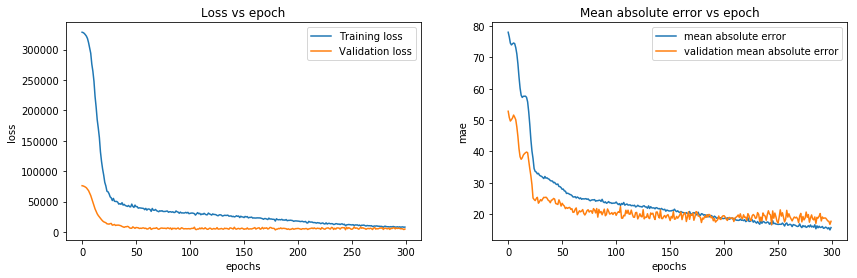

In [151]:
plothistory(history)

In [152]:
def seepredictions(model):
    df_validation = df.loc[df.index[range(train,validation)]].copy()
    #df.tail(len(df)-train).head(validation) #this should work too
    pred = model.predict(x_validate)*1000
    df_validation['Predictions']=pred
    df_validation['DiffPercentage']=abs(df_validation['Predictions']-df_validation['POP10'])/df_validation['POP10']*100
    return df_validation

In [160]:
print('mean percentage diff = ', seepredictions(model)['DiffPercentage'].mean())
val_df = seepredictions(model)
val_df.head()

mean percentage diff =  93.44596676411943


,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype,Predictions,DiffPercentage
2454,18315006,0,36.309616,-78.584242,Oxford,9174,NC,C,11357.858398,23.804866
2579,7014873,16249,41.006614,-95.892941,Plattsmouth,6596,NE,C,12054.495117,82.754626
205,949993185,11742933,30.427885,-91.038912,Baton Rouge,594309,LA,U,878530.312500,47.823828
2591,22650152,1331720,41.318598,-74.939958,Pocono Woodland Lakes,7020,PA,C,8001.348633,13.979325
382,9347987,91039,38.619270,-78.789794,Broadway,6228,VA,C,6334.313965,1.707032


In [161]:
#analyze
l = len(val_df)
val_df.sort_values('DiffPercentage').tail(20)

,ALAND,AWATER,LAT,LONG,NAME,POP10,STATE,UAtype,Predictions,DiffPercentage
632,3409084,829947,46.823528,-122.473754,Clearwood,2611,WA,C,11378.000000,335.771735
3296,6253036,3903,32.528529,-95.638702,Van,2502,TX,C,10932.035156,336.931861
184,4389497,0,44.392235,-68.221800,Bar Harbor,2575,ME,C,11284.799805,338.244653
3229,7579854,0,34.879831,-85.502036,Trenton,2850,GA,C,12566.133789,340.916975
377,8155132,0,38.727397,-75.589709,Bridgeville,3343,DE,C,14864.115234,344.634018
2645,2733128,0,27.358853,-98.125044,Premont,2620,TX,C,11940.645508,355.749829
3155,9297289,157655,32.744121,-81.643547,Sylvania,3076,GA,C,14413.988281,368.595198
1058,4993626,0,34.496712,-79.116050,Fairmont,2507,NC,C,11931.833008,375.940686
2838,8148008,9174,33.938824,-78.113638,St. James,2604,NC,C,12404.000977,376.344124
2405,3906852,0,42.027095,-96.100484,Onawa,2662,IA,C,12962.300781,386.938422


Model is predicting high values only. It's because of the loss function.